# Your First RNN

**Exercise objectives**:

- Better understand temporal data
- Build your first Recurrent Neural Network


<hr>
<hr>

## 1. The data

Let's start with simple sequences of observations:

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = "darkgrid")

2023-03-21 13:55:59.580743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 13:56:00.072095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 13:56:00.072257: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-21 13:56:02.182187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
#Load the files X.sav and Y.sav and store them in two arrays X and y
X = np.load("X.sav", allow_pickle=True)
y = np.load("Y.sav", allow_pickle=True)


In [4]:
print(X.shape)
print(X[0])

(25000, 10, 3)
[[  1.436 113.    197.   ]
 [  1.725 116.    197.   ]
 [  2.144 116.    197.   ]
 [  2.202 116.    197.   ]
 [  2.341 116.    166.   ]
 [  2.449 143.    166.   ]
 [  6.088 143.    108.   ]
 [  6.169 107.    108.   ]
 [  2.656 107.    108.   ]
 [  2.848 107.    108.   ]]


In [5]:
print(y.shape)
print(y[0])

(25000,)
2.872


☝️ The data describes the evolution of the **employment status of a person, year after year**: each sequence corresponds to 10 consecutive years, where each year describes a job situation, comprising of 3 components
- the salary,
- the number of persons under one's responsability,
- the size of the company. 

So, from this 25000 sequences, each of 10 consecutive observations, the goal is to predict the salary on the 11th year based on the past observations. 

❓ **Question** ❓ Take some sequences and plot the evolution of their salaries, of the persons under their responsibility and of the company sizes. You might see some correlation between the three variables.

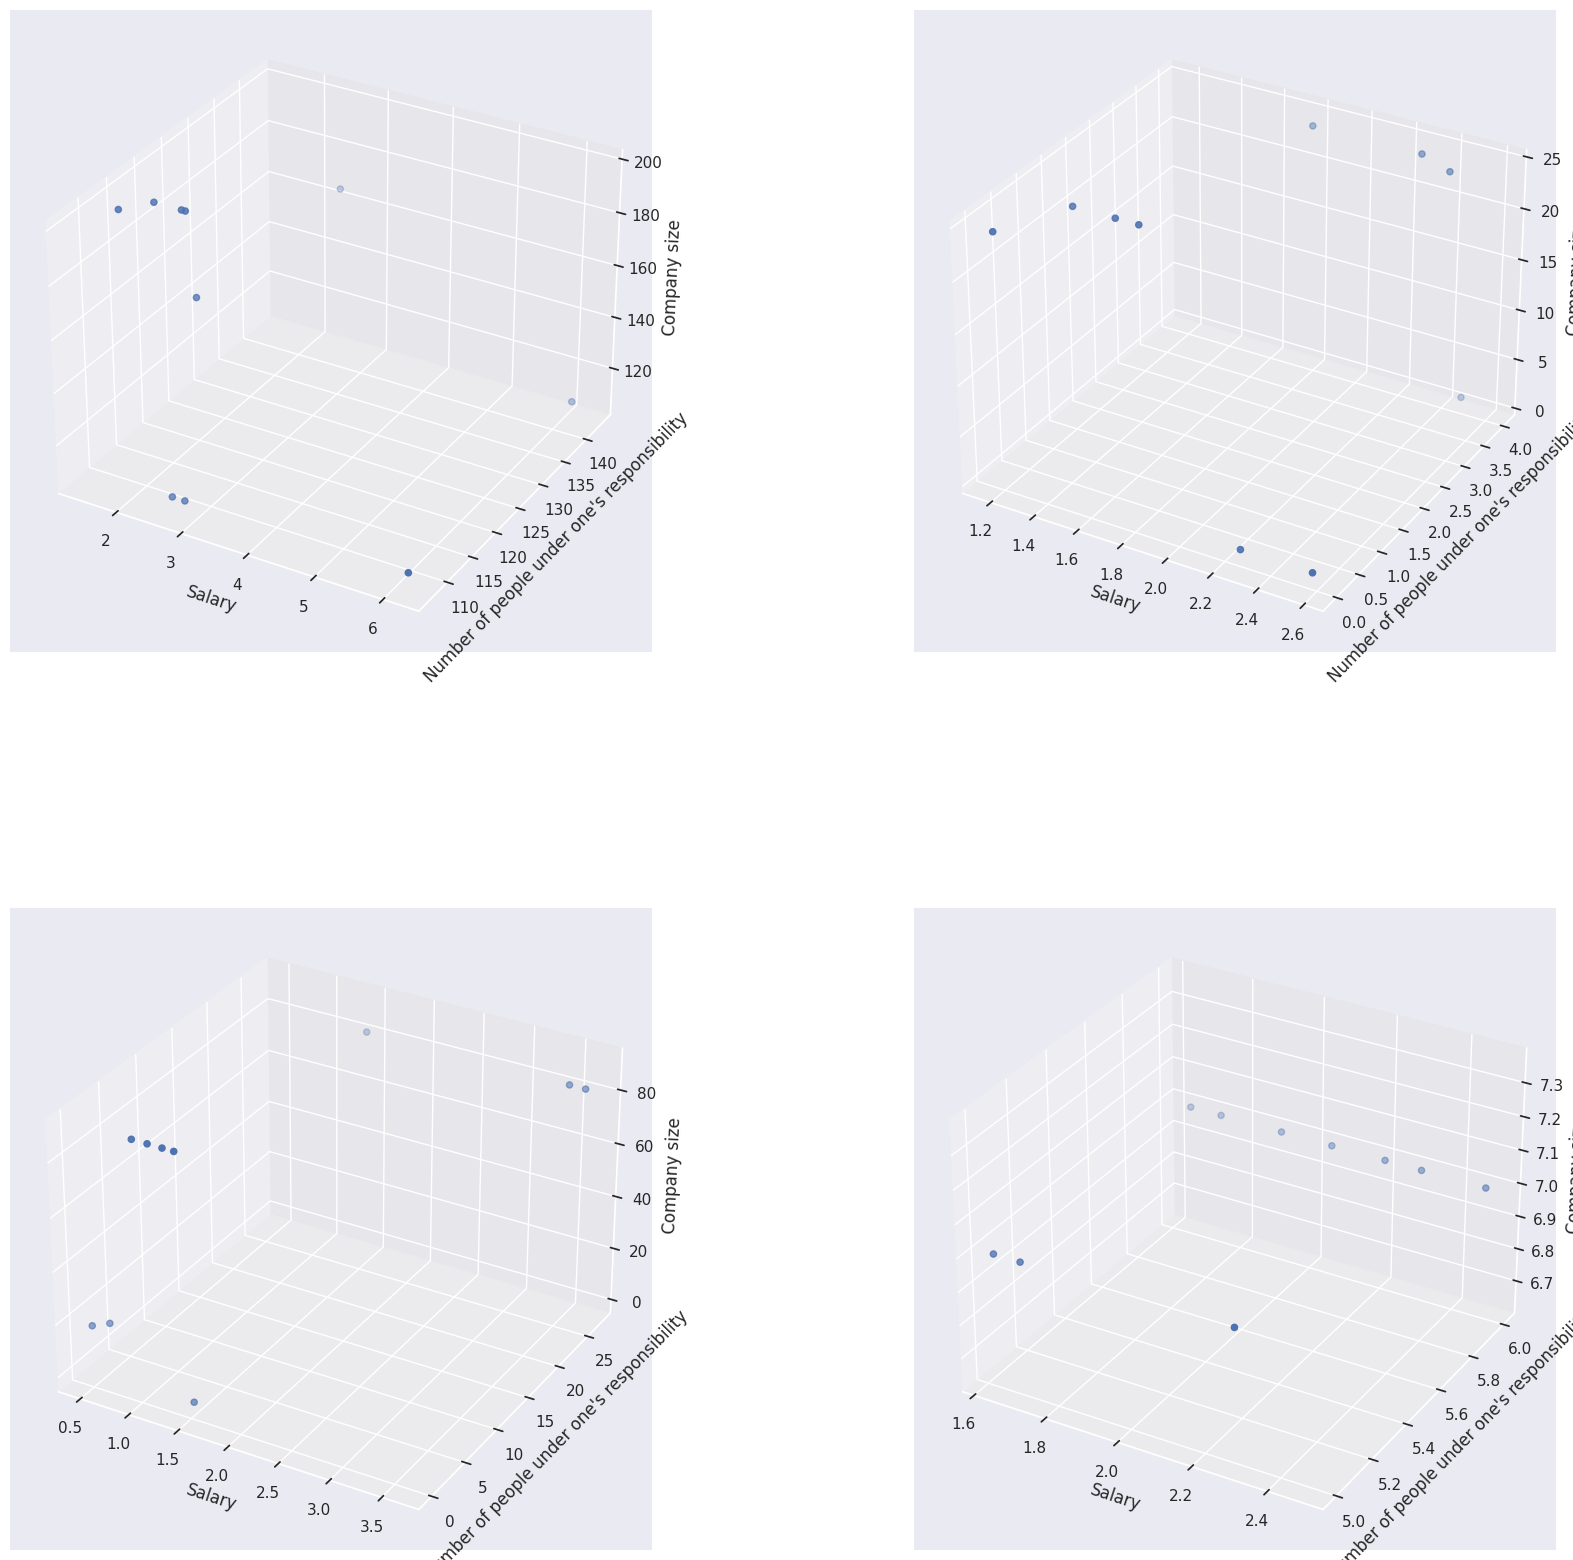

In [6]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(4): 
    ax = fig.add_subplot(2, 2, i+1, projection='3d')

    x_ = X[i, :, 0]
    y_ = X[i, :, 1]
    z_ = X[i, :, 2]

    ax.set_xlabel("Salary")
    ax.set_ylabel("Number of people under one's responsibility")
    ax.set_zlabel("Company size")

    ax.scatter(x_, y_, z_)


❓ **Question** ❓ Plot the distribution of all the salaries, persons under one's responsibility, and company sizes to get a better understanding of the variability of observations

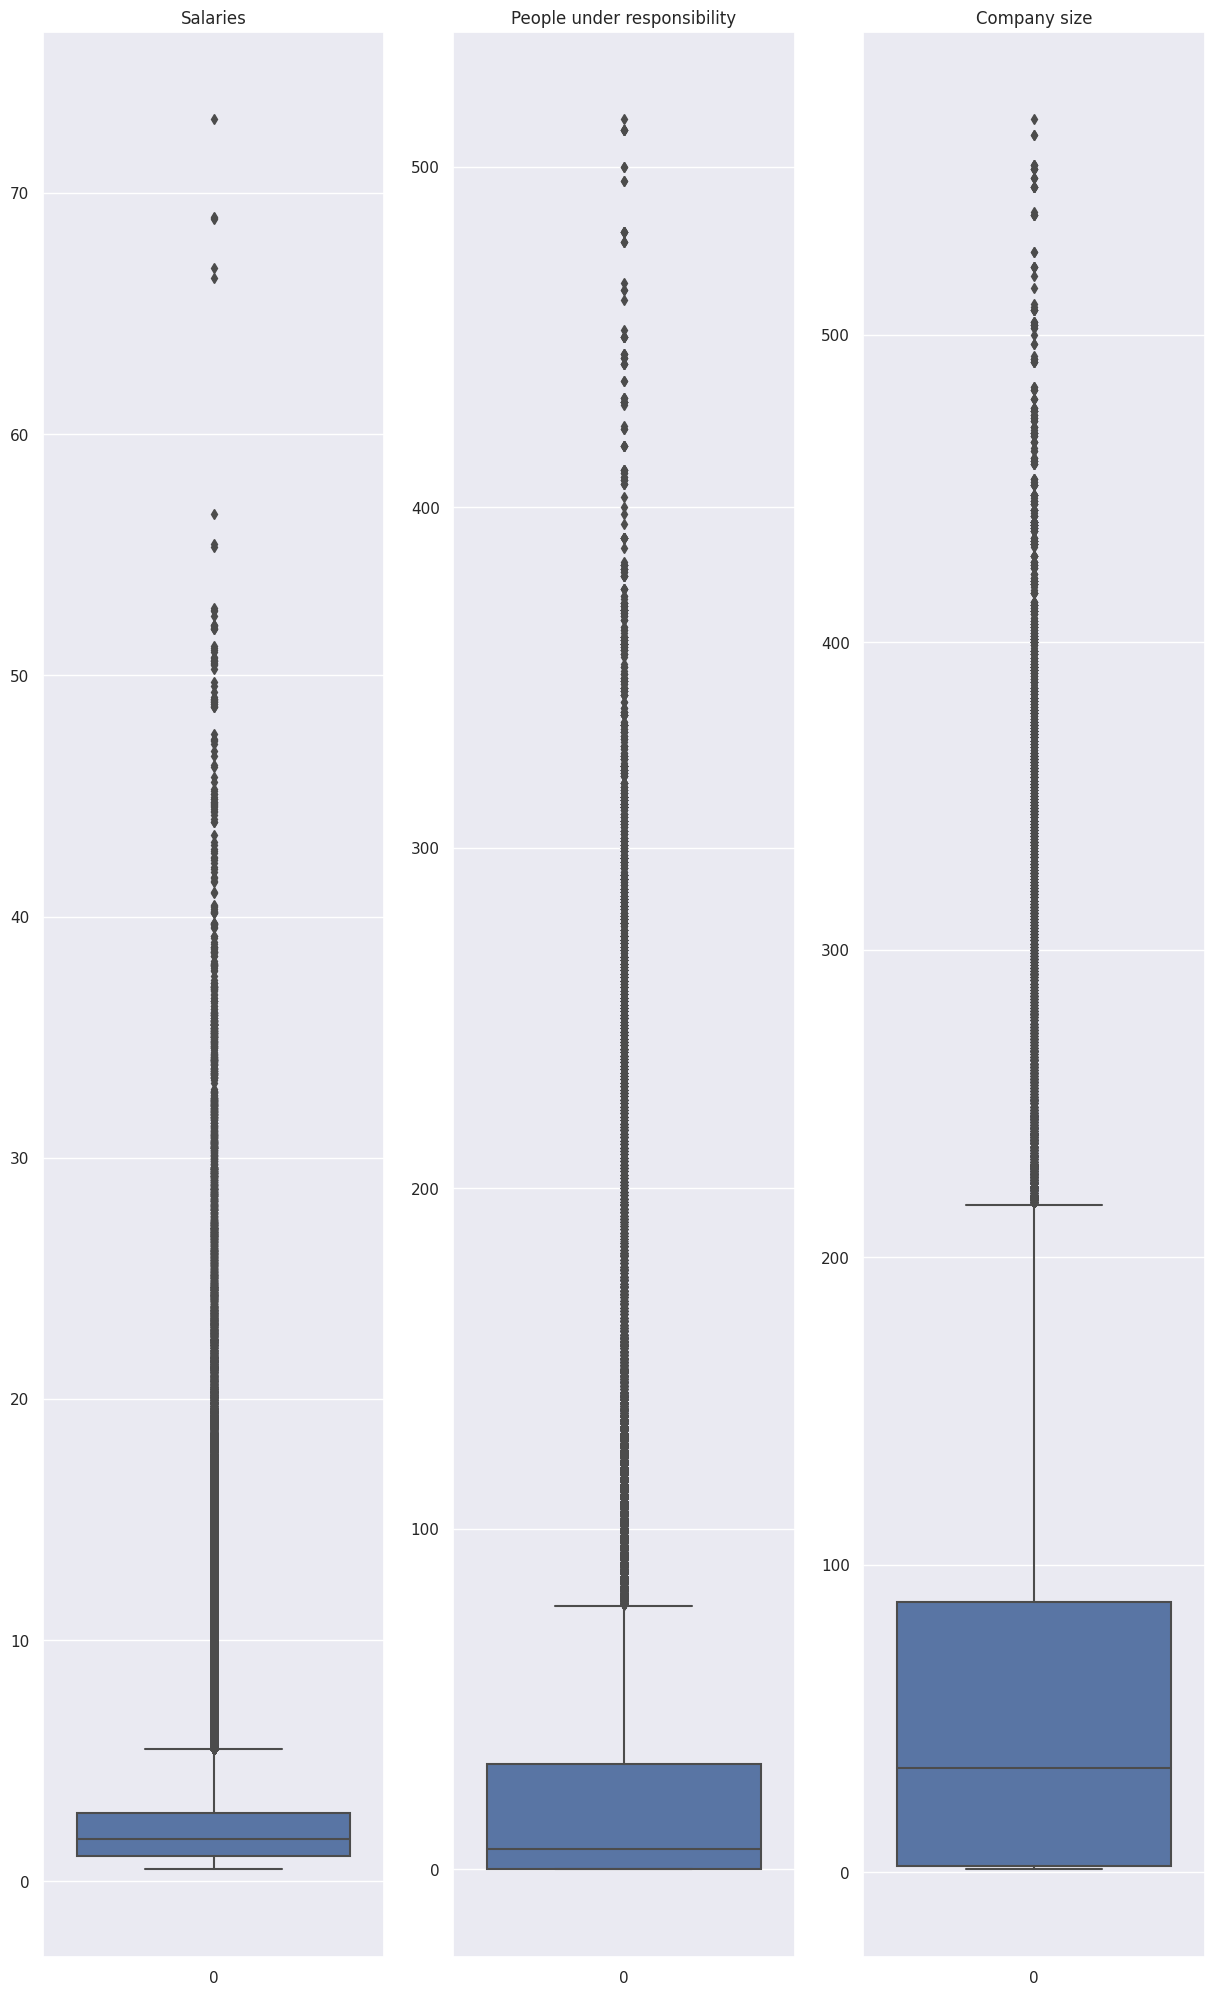

In [7]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 25)

titles = ["Salaries",
          "People under responsibility",
          "Company size"]

for i in range(len(titles)):
    plot = sns.boxplot(X[:, :, i].flatten(), ax=axes[i])
    #plot.set(yscale="log")
    plot.set_title(titles[i])

❓ **Question** ❓  Split your dataset between a train and test set (20/80%)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. A Simple RNN

Now, you will create your first Recurrent Neural Network. Let's start simple

❓ **Question** ❓ Write a model that has: 
- a `Normalization` layer adapted on the training set
- a `SimpleRNN` layer with 20 `units` - don't forget to choose the `tanh` activation function
- a Dense layer with 10 neurons
- a last Dense layer specific to your task (predict a salary)

Remember, you don't need to specify an `input_shape`: as soon as your normalizer has been adapted to your train set, it has memorized it.

In [20]:
from keras.layers import Normalization
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, LSTM
from keras.callbacks import EarlyStopping


model = Sequential()

norm = Normalization()
norm.adapt(X_train)
model.add(norm)

rnn = SimpleRNN(units=20,
                activation="tanh")
model.add(rnn)

dense_layer = Dense(10)
model.add(dense_layer)

output_layer = Dense(1, activation="relu")
model.add(output_layer)




❓ **Question** ❓ Compute the number of trainable parameters of your model using `model.summary`. 

Then, try to recompute them by hand

💡 Hints: 
- Your `normalization` layer has 7 non-trainable params, which comprise of the mean and standard deviation of each 3 features (salary, persons under responsibility, company size) plus one bias set to 0

- If $\color{green}{n_h}$ RNN units are applied in parallel to $\color{red}{n_x}$ features, the layer has $\color{green}{n_h}(\color{green}{n_h} + \color{red}{n_x} + 1)$ parameters to train. Notice how this number is *independent* of the length of each sequences (here 10 days)


In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 3)          7         
 n)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                480       
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 708
Trainable params: 701
Non-trainable params: 7
_________________________________________________________________
None


❓ **Question** ❓ Compile your model. Remember to first use the `rmsprop` optimizer (instead of Adam).

In [11]:
model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics='mean_absolute_error')

❓ **Question** ❓ Run your model on your data. Use a validation split of 20% and an early stopping criterion (patience=5). Evaluate your performance on the test set

In [12]:
stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

model.fit(x=X_train,
          y=y_train,
          epochs=100,
          verbose=2,
          callbacks=[stop],
          validation_split=0.2)

print(f"Mean absolute error on testing data: {model.evaluate(X_test, y_test)[1]}")


Epoch 1/100
500/500 - 4s - loss: 1.3750 - mean_absolute_error: 1.3750 - val_loss: 0.6010 - val_mean_absolute_error: 0.6010 - 4s/epoch - 8ms/step
Epoch 2/100
500/500 - 2s - loss: 0.5377 - mean_absolute_error: 0.5377 - val_loss: 0.4543 - val_mean_absolute_error: 0.4543 - 2s/epoch - 4ms/step
Epoch 3/100
500/500 - 2s - loss: 0.4422 - mean_absolute_error: 0.4422 - val_loss: 0.3647 - val_mean_absolute_error: 0.3647 - 2s/epoch - 4ms/step
Epoch 4/100
500/500 - 2s - loss: 0.4018 - mean_absolute_error: 0.4018 - val_loss: 0.3119 - val_mean_absolute_error: 0.3119 - 2s/epoch - 4ms/step
Epoch 5/100
500/500 - 2s - loss: 0.3775 - mean_absolute_error: 0.3775 - val_loss: 0.2943 - val_mean_absolute_error: 0.2943 - 2s/epoch - 4ms/step
Epoch 6/100
500/500 - 2s - loss: 0.3649 - mean_absolute_error: 0.3649 - val_loss: 0.3363 - val_mean_absolute_error: 0.3363 - 2s/epoch - 4ms/step
Epoch 7/100
500/500 - 2s - loss: 0.3574 - mean_absolute_error: 0.3574 - val_loss: 0.3216 - val_mean_absolute_error: 0.3216 - 2s/ep

# Baseline comparison?


In the case of a usual regression model, a baseline prediction for `y_test` could be to predict the average of `y_train`.

With temporal data, it often happens that you try to predict a value that you have already seen in the past: here, the salary. In that case, a baseline model could be to predict for instance that the 11-th salary is equal to the 10-th salary.

❓ **Question** ❓ Compute the Mean Absolute Error of a model that would predict that the salary remains constant between the 10-th and 11-th year and compare it to your RNN.

In [19]:
from sklearn.metrics import mean_absolute_error
final_year_salary = np.mean(X_train[:, 9, 0])

baseline_mae = mean_absolute_error(np.array([final_year_salary]*len(y_test)), y_test)
print(f"Baseline mean absolute error: {baseline_mae}")

Baseline mean absolute error: 3.3828482293


You have probably seen that your prediction is a little bit better than the baseline model

# LSTM

❓ **Question** ❓ Write the exact same model, but with a `LSTM` instead of a `SimpleRNN` and evaluate your performance on the test set

In [21]:
model = Sequential()

norm = Normalization()
norm.adapt(X_train)
model.add(norm)

rnn = LSTM(units=20,
                activation="tanh")
model.add(rnn)

dense_layer = Dense(10)
model.add(dense_layer)

output_layer = Dense(1, activation="relu")
model.add(output_layer)

model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics='mean_absolute_error')

stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

model.fit(x=X_train,
          y=y_train,
          epochs=100,
          verbose=2,
          callbacks=[stop],
          validation_split=0.2)

print(f"Mean absolute error on testing data: {model.evaluate(X_test, y_test)[1]}")

Epoch 1/100
500/500 - 4s - loss: 1.6818 - mean_absolute_error: 1.6818 - val_loss: 0.6263 - val_mean_absolute_error: 0.6263 - 4s/epoch - 8ms/step
Epoch 2/100
500/500 - 2s - loss: 0.5259 - mean_absolute_error: 0.5259 - val_loss: 0.3882 - val_mean_absolute_error: 0.3882 - 2s/epoch - 4ms/step
Epoch 3/100
500/500 - 2s - loss: 0.3816 - mean_absolute_error: 0.3816 - val_loss: 0.3204 - val_mean_absolute_error: 0.3204 - 2s/epoch - 4ms/step
Epoch 4/100
500/500 - 2s - loss: 0.3427 - mean_absolute_error: 0.3427 - val_loss: 0.3054 - val_mean_absolute_error: 0.3054 - 2s/epoch - 4ms/step
Epoch 5/100
500/500 - 2s - loss: 0.3224 - mean_absolute_error: 0.3224 - val_loss: 0.2966 - val_mean_absolute_error: 0.2966 - 2s/epoch - 4ms/step
Epoch 6/100
500/500 - 2s - loss: 0.3089 - mean_absolute_error: 0.3089 - val_loss: 0.3329 - val_mean_absolute_error: 0.3329 - 2s/epoch - 4ms/step
Epoch 7/100
500/500 - 2s - loss: 0.2985 - mean_absolute_error: 0.2985 - val_loss: 0.2971 - val_mean_absolute_error: 0.2971 - 2s/ep

## 🏁 Congratulation

You now know how to run RNN on sequence data!

Note: The sequences you worked with are totally fake. In case you need to train and reproduce similar data, you can find bellow the functions that have been used to simulate this data.

# Utils (for reference only)

In [15]:
def create_sequences(number):
    X, y = [], []
    
    for i in range(number):
        x_i, y_i = create_individual_sequence(10)
        X.append(x_i)
        y.append(y_i)
        
    return np.array(X), np.array(y)
            
def create_individual_sequence(length):
    company_sizes = []
    nb_persons = []
    salaries = []
    
    
    # Education level
    educ_level = [max(0, int(np.random.normal(10, 2)))]*length
    
    # Company size
    current_size = int(1 + np.random.beta(.4, 4)*500)
    for i in range(length):
        if not np.random.randint(4): # Change 1 out of 3 possibilities 
            current_size = int(max(1, np.random.normal(current_size, 50)))
        company_sizes.append(current_size)
    
    # Number of persons
    nb_iter = np.random.beta(.15, 4)*300
    for i in range(length):
        if not np.random.randint(2): # Change 1 out of 2 possibilities
            R_1 = np.random.beta(0.5, 8)*3
            nb_iter = nb_iter + max(-2, R_1*company_sizes[i] + np.random.randint(-2, 2))
            nb_iter = max(0, nb_iter)
            nb_iter = int(min(company_sizes[i]-1, nb_iter))
        nb_persons.append(nb_iter)
        
    
    # Salary
    salary_iter = max(800, int(np.random.normal(1200, 300)+ 0.05*company_sizes[0] +  np.random.normal(40, 400)))
    salaries.append(salary_iter)
    for i in range(1, length + 1):
        R_1 = np.random.normal(100, 50)
        change_person = nb_persons[i-1] - nb_persons[i-2]
        change_company = max(0, company_sizes[i-1] - company_sizes[i-2])
        salary_iter = salary_iter + 0.05*change_company + change_person*R_1 + np.random.normal(100, 50)
        salary_iter = max(int(salary_iter), 500)
        
        salaries.append(salary_iter)

    y = salaries[-1]/1000
    salaries = [_/1000 for _ in salaries[:-1]]
    
    return np.array([salaries, nb_persons, company_sizes]).T, y

In [16]:
#X, y = create_sequences(25000)

#np.save('X', X.astype(np.float32))
#np.save('y', y)